### Compute financial indexes

#### Workflow: 
- df_price : OK get price data
- df_indicators : OK compute df_ta 
- df_indicators : OK compute df_sympy
- df_indicators : OK normalize
- logic_string : OK create logic_string with df_indicators
- eval(logic_string) : OK eval logic_string with df_sympy
- df_signal : OK return signal over time
- model['performances'] = backtest(df_signal,df_price) #with backtrader.py
- fitness = get_fitness(model['performances'])
- pop.append(model)
- save_bests(model)

- run GA with initial population (from the 2#)

In [1]:
model =  {'fitness':0.0,
           'mutated':False,
            'name':'unknown',
            'ticker':'',
            'leverage':0,'performance':{},
            'logic':'',
            'model':{},
            'performance':{}
            }

In [2]:
import sys
from copy import copy, deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook


In [3]:
path_df = sys.path[0].replace('notebooks','source/data/ETHUSD_2021_minute.csv')

In [4]:
df = pd.read_csv(path_df,skiprows=1,parse_dates=['date'], index_col=['date'])
df.sort_values(by=['date'], inplace=True, ascending=True)

In [5]:
del df['unix']
del df['symbol']
del df['Volume ETH']

In [6]:
df.rename({'Volume USD': 'volume'},axis=1, inplace=True)

In [7]:
df_price = df.copy()

In [8]:
df.head()

,open,high,low,close,volume
date,,,,,
2021-01-01 00:01:00,738.63,740.50,738.63,740.50,11147.529979
2021-01-01 00:02:00,739.02,739.02,739.02,739.02,43.164436
2021-01-01 00:03:00,739.02,739.02,739.02,739.02,0.000000
2021-01-01 00:04:00,738.31,738.60,738.31,738.60,26700.411434
2021-01-01 00:05:00,738.28,738.28,736.81,736.81,27394.208503


In [9]:
cols = [i for i in list(df.columns)] # show me all the columns
print(cols)

['open', 'high', 'low', 'close', 'volume']


In [10]:
df.isna().sum()  #check for nan values

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [11]:
import pandas_ta

In [12]:
sma10 = df.ta.sma(length=10) 

In [13]:
sma10

date
2021-01-01 00:01:00         NaN
2021-01-01 00:02:00         NaN
2021-01-01 00:03:00         NaN
2021-01-01 00:04:00         NaN
2021-01-01 00:05:00         NaN
                         ...   
2021-12-31 07:14:00    3743.464
2021-12-31 07:15:00    3742.040
2021-12-31 07:16:00    3740.446
2021-12-31 07:17:00    3738.893
2021-12-31 07:18:00    3737.407
Name: SMA_10, Length: 524598, dtype: float64

In [14]:
my_indicator ='sma-10'
my_df_indicator = pd.DataFrame()

In [15]:
def compute_financial_indexes(financial_index,df_price , df_indicators):
    """
    extract_parameters and call financial indexes equation
    df_indicators can be empty, each call of this function 
    will add a new column with the finance_indicator

       FROM     'sd-60-1' 
       TO       df['sd-60-1']
       
    """
    if '-' in financial_index:
        parameters = financial_index.split('-')

        if 'ema' in financial_index:  # SMA
                df[financial_index] = df.ta.ema(length= int(parameters[1]))
            
        elif 'sd' in financial_index: # SD
                df[financial_index] = df.ta.sd(length= int(parameters[1]))

        elif 'roc' in financial_index:
                df[financial_index] = df.ta.roc(length= int(parameters[1]))

        elif 'sma' in financial_index:
                df[financial_index] = df.ta.sma(length= int(parameters[1]))
        else:
            pass
        
    else:
        print('MyError @ compute_financial_indexes() Problem: no index found')

    return df

In [16]:
my_df_indicator = compute_financial_indexes(financial_index='ema-18',df_price=df ,df_indicators=my_df_indicator)

In [17]:
my_df_indicator = compute_financial_indexes(financial_index='sma-4',df_price=df ,df_indicators=my_df_indicator)

In [18]:
my_df_indicator = compute_financial_indexes(financial_index='roc-7',df_price=df ,df_indicators=my_df_indicator)

In [19]:
my_df_indicator.tail(2)

,open,high,low,close,volume,ema-18,sma-4,roc-7
date,,,,,,,,
2021-12-31 07:17:00,3735.55,3735.55,3733.53,3734.44,6391.276379,3740.233110,3733.5950,-0.297151
2021-12-31 07:18:00,3733.14,3733.14,3729.29,3729.69,1879.678872,3739.123309,3733.0475,-0.311119


In [20]:
from sympy import *

In [21]:
x, y, z = symbols('x y z')
k, m, n = symbols('k m n', integer=True)

In [22]:
str_expr = "x**2 + 3*x - 1/2"
str_expr2 = "x*1/2"

In [23]:
expr = trigsimp(sin(x)**4 - 2*cos(x)**2*sin(x)**2 + cos(x)**4)
expr

cos(4*x)/2 + 1/2

In [24]:
def subtitute_expression_to_index(my_array,equation): 
    """
    Apply the equation to the ARRAY with the lambdify equation
     
    transform the equation obj type from string in sympy equation 
    x=symbol, expression['equation'], 'numpy'= computation method
            
            # ONLY x IS FIXED, need for y,z, and so...    
    """
    #array =np.array(array)
    f = lambdify(x, equation,"numpy")     
    signal_data = f(my_array)
    #signal_data = pd.Series(signal_data)            
    return(signal_data)

In [25]:
index_sympy_series = subtitute_expression_to_index(my_df_indicator['ema-18'],str_expr2)
index_sympy_series2 = subtitute_expression_to_index(my_df_indicator['sma-4'],str_expr)

In [26]:
print('DATA-TYPE '+str(type(index_sympy_series)))
print('LAST-ROW',index_sympy_series.tail(5))

DATA-TYPE <class 'pandas.core.series.Series'>
LAST-ROW date
2021-12-31 07:14:00    1871.314930
2021-12-31 07:15:00    1870.862306
2021-12-31 07:16:00    1870.457326
2021-12-31 07:17:00    1870.116555
2021-12-31 07:18:00    1869.561654
Name: ema-18, dtype: float64


In [27]:
def n1(nparray):
    """ ( array - Min) / (Max - Min) """
    return (nparray - np.min(nparray)) / (np.max(nparray) - np.min(nparray))
    
#@jit(nopython=True)
def n2(nparray):
    """(array - mean) / sd """
    return (nparray - np.mean(nparray) ) / np.std(nparray)

In [28]:
a=n1(index_sympy_series)
b=n2(index_sympy_series2)

In [29]:
a.tail(1)

date
2021-12-31 07:18:00    0.730313
Name: ema-18, dtype: float64

In [30]:
b.tail(1)

date
2021-12-31 07:18:00    0.875535
Name: sma-4, dtype: float64

In [31]:
my_df_indicator['A-ema-18-0x129292-n1']=a
my_df_indicator['B-sma-4-0x231020-n2']=b

In [32]:
my_df_indicator.tail(1)

,open,high,low,close,volume,ema-18,sma-4,roc-7,A-ema-18-0x129292-n1,B-sma-4-0x231020-n2
date,,,,,,,,,,
2021-12-31 07:18:00,3733.14,3733.14,3729.29,3729.69,1879.678872,3739.123309,3733.0475,-0.311119,0.730313,0.875535


<IPython.core.display.Javascript object>


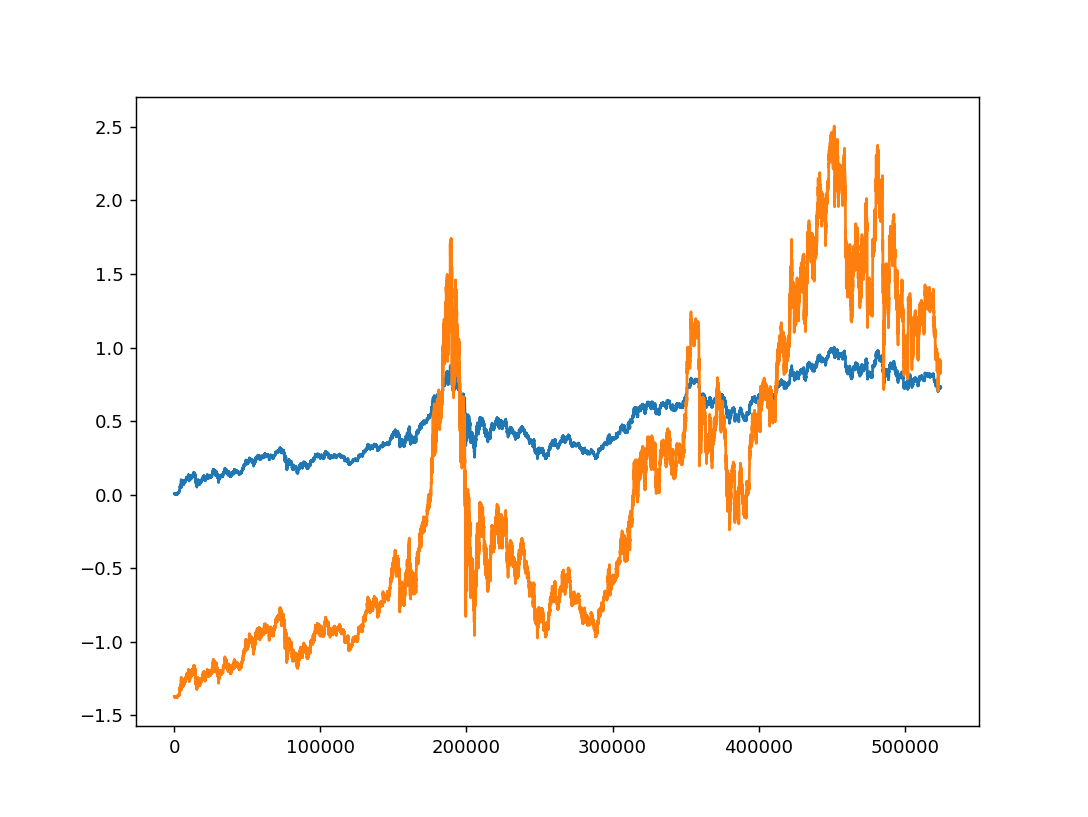

In [49]:
plt.plot(range(len(my_df_indicator)),my_df_indicator['A-ema-18-0x129292-n1'])
plt.plot(range(len(my_df_indicator)),my_df_indicator['B-sma-4-0x231020-n2'])



In [34]:
logic='A>B'
name_df_ram = 'my_df_indicator'

keyA='A-ema-18-0x129292-n1'
keyB='B-sma-4-0x231020-n2'

logic=logic.replace('A',name_df_ram+"['"+keyA+"']")
logic=logic.replace('B',name_df_ram+"['"+keyB+"']")

logic

"my_df_indicator['A-ema-18-0x129292-n1']>my_df_indicator['B-sma-4-0x231020-n2']"

#### <span style='color:Blue'> Generate Signal with _eval()_ & Logic String </span>

In [38]:
df_price['signal'] = eval(logic)

In [39]:
df_price['signal'].any()

True

In [40]:
df_price['signal']=df_price['signal'].map({False: 'pass', True: 'open'})

In [41]:
df_price.head(5)

,open,high,low,close,volume,signal
date,,,,,,
2021-01-01 00:01:00,738.63,740.50,738.63,740.50,11147.529979,pass
2021-01-01 00:02:00,739.02,739.02,739.02,739.02,43.164436,pass
2021-01-01 00:03:00,739.02,739.02,739.02,739.02,0.000000,pass
2021-01-01 00:04:00,738.31,738.60,738.31,738.60,26700.411434,pass
2021-01-01 00:05:00,738.28,738.28,736.81,736.81,27394.208503,pass


In [42]:
df_price.columns

Index(['open', 'high', 'low', 'close', 'volume', 'signal'], dtype='object')

In [48]:
plt.plot(range(len(df_price)),df_price['close'])
plt.plot(range(len(df_price)),df_price['signal'].map({'pass':min(df_price['close']),'open':max(df_price['close'])}  ))
plt.show()

### <span style='color:Blue'> Backtest signal </span>

In [ ]:
take_profit=0.053
stop_loss = 0.1

def backtest(df , equity=100_000):
    """ df 
    Columns ['open', 'high', 'low', 'close', 'volume', 'signal']
    datetime as Index
    """
    initial_investment = equity    
    
    open_operation = False
    id_op=0
    gain=0
    equity_history=[]
        
    for i in range(buffer_period):
        equity_history.append(equity)
    
    for i in range(buffer_period, len(df)):       
        if open_operation==False:
            if df['signal'][i]=='open': # Open Long position #####
                open_operation = True
                id_op+=1
                op_open_price = deepcopy(df['close'][i])
                op_open_date = deepcopy(df.index[i])
                size_order = equity / df['close'][i]    
                #print(op_open_price,op_open_date)

                print(' id: ',id_op)
                print(' open long position date:',op_open_date)
                print(' price opening operation:',op_open_price)
        
                print(' Signal datetime ',df.index[i])
        
        
                print(' equity: ',round(equity,2))
                print(' size order: ',size_order)
                print('-'*80)

        actual_price = df['close'][i] 
        actual_date = deepcopy(df.index[i])


        if open_operation==True: # Open buy price
            gain =  size_order * (actual_price-op_open_price)         
            real_TP = take_profit*equity
            real_SL = stop_loss*equity
            timedelta = (actual_date-op_open_date)/60 # minutes between open operation time and now 

            if ( (gain > real_TP) or (gain < -real_SL) ):# and timedelta.seconds >30000:  # Close Long position ###        
                open_operation = False
                equity += gain
                print(' id: ',id_op)
                
                print(' open long position date:  ',op_open_date)
                print(' close long position date:  ',actual_date)
                
                print(' price opening operation:',op_open_price)
                print(' prince closing operation: ',actual_price)
                
                print(' equity: ',round(equity,2))
                print(' size order: ',size_order)
                print(' gain ',round(gain,3),'$')
                print('-'*80)
                gain=0

        #equity += gain      
        if equity <= initial_investment*0.7:
             break
        equity_history.append(equity)
    return equity_history

buffer_period = 200
df_price['TS_equity'] = backtest( df_price)

#print('any signal:',my_signal.any())
# print()
# #print('EQUITY: ',equity)
# print()
# print('',my_signal)


In [ ]:
investment = 100_000

In [ ]:
initial_amout = 135.043889
initial_amout = investment/df_price['close'][0]

In [ ]:
df_price['benchmark'] = initial_amout*df_price['close']

In [ ]:
df_price

In [ ]:
plt.plot(range(len(df_price)),df_price["benchmark"])
plt.plot(range(len(df_price)),df_price["equity"])

In [ ]:
df_plot = df_price[['close','equity']][:300]

In [ ]:
sns.set()

In [ ]:
sns.lineplot(data=df_plot,palette="tab10", linewidth=2.5)
plt.show()

### <span style='color:Blue'> Performance against benchmark: alpha & beta </span>

In [ ]:
investment=100_000

In [ ]:
benchmark_gain = (df_price['close'][-1] / df_price['close'][0])*100
print('benchmark gain: ',round(benchmark_gain,2),' %')

In [ ]:
trading_strategy_gain = (df_price['equity'][-1] / df_price['equity'][0])*100
print('trading strategy gain: ',round(trading_strategy_gain,2),' %')

In [ ]:
alpha=trading_strategy_gain-benchmark_gain # % 
alpha

In [ ]:
benchmark_data = df_price['close']

In [ ]:
TS_data = pd.Series(equity_history)

In [ ]:
log_returns_benchmark = np.log(benchmark_data/benchmark_data.shift())

In [ ]:
log_returns_TS = np.log(TS_data/TS_data.shift())

In [ ]:
var_benchmark = log_returns_benchmark.var()
var_TS = log_returns_TS.var()


In [ ]:
cov = log_returns.cov()
var = log_returns['^GSPC'].var()
 
cov.loc['AAPL', '^GSPC']/var

In [ ]:
cov

In [ ]:
#cov.loc['close','perormance']/var

In [ ]:
def beta(data):
    
    
    #
    return cov

beta(df_price)

In [ ]:
cov = log_returns.cov()
var = log_returns['^GSPC'].var()
cov.loc['AAPL', '^GSPC']/var

In [ ]:
benchmark_gain = (df_benchmark[-1] / df_benchmark[0])*100
print('benchmark gain: ',round(benchmark_gain,2),' %')

In [ ]:
print('Absolute gain: Benchmark ',,'  Trading Strategy ',equity_history[-1])

In [ ]:
print(len(new_signal))
print(len(df_price))

In [ ]:
for i in range(len(my_signal[:10])): 
    print(type(bool(my_signal[i])))

In [ ]:
df_price.index[0]